In [1]:
#My path
path = '/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Deep_learning/Final project/data/dataset/Revco/'

#Your path
#path = '/Users/claes/Desktop/Deep_learning/Week_6'

## Lægge alle data fra hver fryser sammen, klar til autoencoder

In [ ]:
import pandas as pd
import glob
from sklearn.preprocessing import MinMaxScaler

# Step 1: Load all parquet files matching the pattern
all_files = glob.glob(path + "cleaned_data_*.parquet")
#all_files = glob.glob(path + "cleaned_data_806016.parquet")

# Step 2: Define the columns to drop (conditionally)
drop_columns_set_1 = ['Datetime', 'State', 'Type', 'Event']
drop_columns_set_2 = drop_columns_set_1 + ['main_fault']

# Step 3: Initialize a list to store dataframes
dfs = []

# Step 4: Load, preprocess, and concatenate data
for file in all_files:
    df = pd.read_parquet(file)
    
    # Drop columns that exist in the dataframe
    if 'main_fault' in df.columns:
        df.drop(columns=[col for col in drop_columns_set_2 if col in df.columns], inplace=True)
    else:
        df.drop(columns=[col for col in drop_columns_set_1 if col in df.columns], inplace=True)
    
    # Append the processed dataframe to the list
    dfs.append(df)

# Step 5: Combine all dataframes into one
combined_df = pd.concat(dfs, axis=0, ignore_index=True)

# Step 6: Normalize the combined dataset
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(combined_df)

# Convert back to a DataFrame for easier handling (optional)
normalized_df = pd.DataFrame(data_normalized, columns=combined_df.columns)

normalized_df.to_parquet(path + 'combined_cleaned_data.parquet', index=False)


In [ ]:
print(f"Længde af combined df: {normalized_df.shape[0]:,}")

In [3]:
import pandas as pd
import glob
import time
from joblib import Parallel, delayed

window_size = 60

start_time = time.time()  # Track total time

# Step 1: Load all parquet files matching the pattern
all_files = glob.glob(path + "trimmed_data_*.parquet")
#all_files = glob.glob(path + "cleaned_data_*.parquet")

for file in all_files:
    print(file)

# Step 2: Define the columns to drop (conditionally)
drop_columns_set_1 = ['State', 'Type', 'Event']
drop_columns_set_2 = drop_columns_set_1 + ['main_fault']

# Step 3: Initialize a list to store dataframes
dfs = []

# Step 4: Load, preprocess, and concatenate data
for file in all_files:
    df = pd.read_parquet(file)
    
    # Drop columns that exist in the dataframe
    if 'main_fault' in df.columns:
        df.drop(columns=[col for col in drop_columns_set_2 if col in df.columns], inplace=True)
    else:
        df.drop(columns=[col for col in drop_columns_set_1 if col in df.columns], inplace=True)
    
    # Append the processed dataframe to the list
    dfs.append(df)

# Step 5: Combine all dataframes into one
combined_df = pd.concat(dfs, axis=0, ignore_index=True)

print("step5")
print(combined_df.head(20))

elapsed_time = time.time() - start_time
print(f"Step 5 time: {elapsed_time:.2f} seconds")

# Step 6: ensure it is in datetime format
combined_df['Datetime'] = pd.to_datetime(combined_df['Datetime'])

print("step6")
print(combined_df.head(20))

elapsed_time = time.time() - start_time
print(f"Step 6 time: {elapsed_time:.2f} seconds")

# Step 7: Identify continuous sequences
# Calculate time difference in seconds
combined_df['time_diff'] = combined_df['Datetime'].diff().dt.total_seconds()

print("step7.1")
print(combined_df.head(20))

# Identify the start of a new sequence
combined_df['is_continuous'] = (combined_df['time_diff'].between(59, 61)) | (combined_df.index == 0)

print("step7.2")
print(combined_df.head(20))

# Assign sequence groups
combined_df['sequence_group'] = (~combined_df['is_continuous']).cumsum()

print("step7.3")
print(combined_df.head(20))

# Step 8: Filter only sequences of at least x continuous rows
valid_sequences = combined_df.groupby('sequence_group').filter(lambda x: len(x) >= window_size)

print(valid_sequences)

elapsed_time = time.time() - start_time
print(f"Step 8 time: {elapsed_time:.2f} seconds")

# Step 9: Create time-windowed and flattened data

def process_group(group):
    # Function to process a single group
    group_windows = []
    timestamps = []  # List to store corresponding timestamps
    for start_idx in range(0, len(group) - window_size + 1):
        # Extract the time window
        window = group.iloc[start_idx:start_idx + window_size]
        # Store the first timestamp of the window
        timestamps.append(window['Datetime'].iloc[0])
        # Flatten the window
        flattened_window = window.drop(
            ['Datetime', 'time_diff', 'is_continuous', 'sequence_group'], axis=1
        ).values.flatten()
        group_windows.append(flattened_window)
    return timestamps, group_windows

# Prepare groups for parallel processing
groups = [group for _, group in valid_sequences.groupby('sequence_group')]

num_cores = -1  # Use all available cores

# Parallel processing using Joblib
print(f"Processing {len(groups)} groups using {num_cores} cores...")
results = Parallel(n_jobs=num_cores)(delayed(process_group)(group) for group in groups)

# Separate timestamps and data
timestamps = [timestamp for result in results for timestamp in result[0]]
time_windows = [window for result in results for window in result[1]]

# Convert to DataFrame
flattened_df = pd.DataFrame(time_windows)
flattened_df['Timestamp'] = timestamps  # Add timestamps

# Save the final DataFrame with timestamps to a parquet file
flattened_df.to_parquet('flattened_time_windows_with_timestamps.parquet', index=False)

/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Deep_learning/Final project/data/dataset/Revco\trimmed_data_806016.parquet
/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Deep_learning/Final project/data/dataset/Revco\trimmed_data_806017.parquet
/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Deep_learning/Final project/data/dataset/Revco\trimmed_data_806018.parquet
step5
              Datetime   RTD  1st Suc.  Cond. Air In  Evap. In  Evap. Out  \
0  2012-08-22 19:51:26 -70.0     -33.0          19.3     -83.0      -77.6   
1  2012-08-22 19:52:26 -71.3     -33.0          19.2     -83.0      -80.4   
2  2012-08-22 19:53:26 -72.4     -33.0          19.3     -83.0      -84.2   
3  2012-08-22 19:54:26 -73.1     -33.2          19.3     -83.0      -86.1   
4  2012-08-22 19:55:26 -74.0     -33.8          19.3     -83.0      -87.0   
5  2012-08-22 19:56:26 -76.1     -33.4          19.7     -83.0      -86.7   
6  2012-08-22 19:57:26 -78.0     -31.9      

In [8]:
df = pd.read_parquet('flattened_time_windows_with_timestamps.parquet')
pd.set_option("display.max_columns", None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,Timestamp
0,-70.0,-33.0,19.3,-83.0,-77.6,-44.8,23.1,48.8,-34.0,-80.0,227.0,-71.3,-33.0,19.2,-83.0,-80.4,-45.7,22.7,48.7,-34.0,-80.0,227.0,-72.4,-33.0,19.3,-83.0,-84.2,-46.8,22.8,48.6,-34.0,-80.0,228.0,-73.1,-33.2,19.3,-83.0,-86.1,-48.0,22.5,48.5,-34.0,-80.0,228.0,-74.0,-33.8,19.3,-83.0,-87.0,-49.1,22.4,48.4,-34.0,-80.0,228.0,-76.1,-33.4,19.7,-83.0,-86.7,-50.1,23.0,48.3,-34.0,-80.0,227.0,-78.0,-31.9,19.7,-83.0,-87.0,-51.2,23.3,48.5,-34.0,-80.0,228.0,-78.2,-31.1,19.7,-83.0,-87.0,-52.5,23.9,48.4,-34.0,-80.0,228.0,-78.4,-31.9,19.8,-83.0,-87.0,-53.5,24.9,47.8,-34.0,-80.0,228.0,-78.5,-30.3,19.9,-83.0,-87.2,-54.8,25.4,47.8,-34.0,-80.0,228.0,-78.7,-30.0,19.6,-83.0,-87.0,-55.3,25.4,47.7,-33.6,-80.0,228.0,-78.8,-31.3,19.3,-83.0,-87.0,-56.0,24.6,47.6,-33.3,-80.0,228.0,-78.9,-32.9,19.0,-82.5,-87.0,-56.2,22.6,47.4,-34.0,-80.0,228.0,-79.0,-33.0,18.5,-82.8,-87.0,-56.0,20.7,47.3,-34.0,-80.0,228.0,-79.0,-33.7,18.3,-82.1,-87.0,-56.7,19.0,46.8,-34.0,-80.0,229.0,-79.0,-34.0,18.1,-82.4,-87.0,-56.0,17.7,46.6,-34.0,-80.0,229.0,-79.9,-34.0,18.1,-82.2,-87.0,-57.0,17.6,46.3,-34.9,-80.0,229.0,-80.0,-34.0,17.7,-82.4,-87.0,-56.1,19.4,46.3,-35.0,-80.0,228.0,-80.0,-34.0,17.7,-82.4,-86.8,-57.0,19.7,45.7,-35.0,-80.0,228.0,-80.0,-34.0,17.6,-83.0,-87.0,-56.3,19.7,45.5,-35.0,-80.0,228.0,-80.0,-34.4,17.5,-82.6,-87.0,-57.0,19.8,45.3,-35.0,-80.0,229.0,-80.8,-34.8,17.4,-83.0,-87.0,-57.2,19.8,45.3,-35.0,-80.0,229.0,-81.0,-35.0,17.3,-83.0,-87.5,-57.7,19.7,44.9,-35.0,-80.0,229.0,-81.0,-3

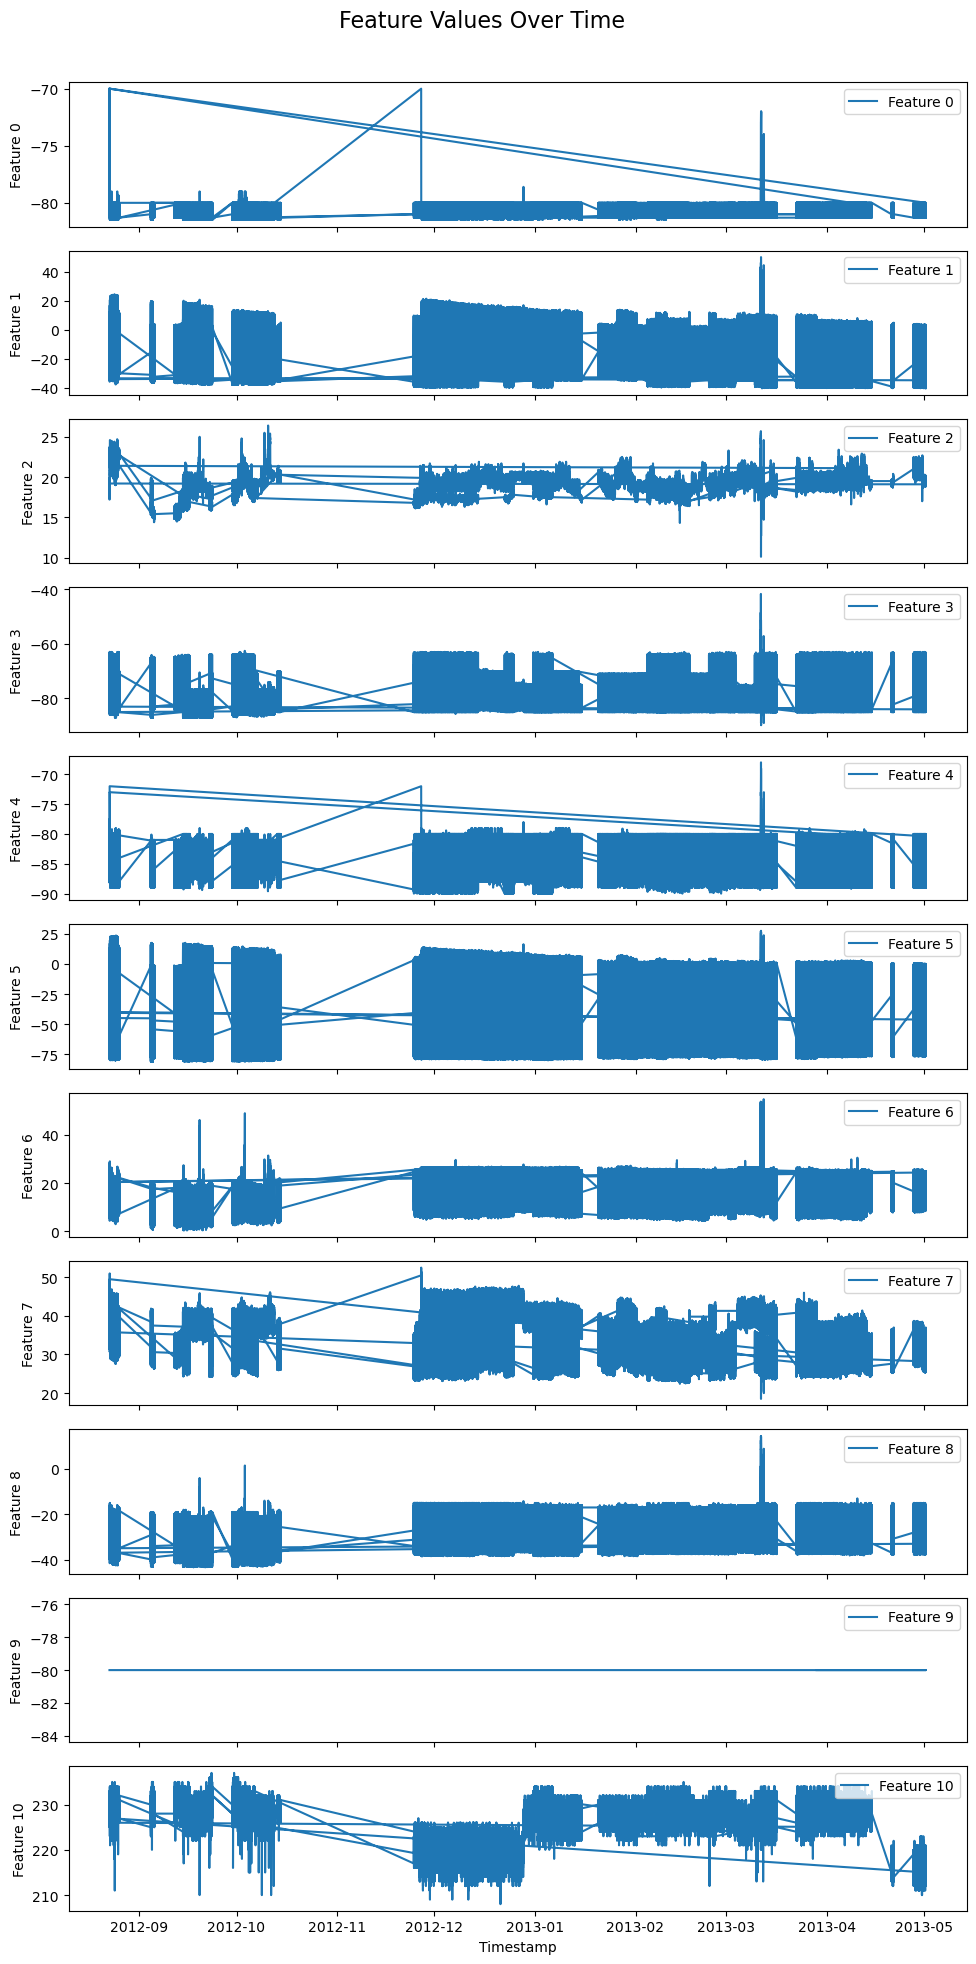

In [7]:
import matplotlib.pyplot as plt

# Define the number of features to plot
num_features = 11

# Create a figure with subplots
fig, axes = plt.subplots(num_features, 1, figsize=(10, 20), sharex=True)

# Plot each feature
for i in range(num_features):
    axes[i].plot(flattened_df['Timestamp'], flattened_df[i], label=f'Feature {i}', color='tab:blue')
    axes[i].set_ylabel(f'Feature {i}')
    axes[i].legend(loc='upper right')

# Set common labels and title
axes[-1].set_xlabel('Timestamp')
fig.suptitle('Feature Values Over Time', fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout to include title

# Show the plot
plt.show()

In [ ]:
elapsed_time = time.time() - start_time
print(f"Step 9 time: {elapsed_time:.2f} seconds")

# Step 10: Normalize each window
scaler = MinMaxScaler()
time_windows_normalized = [scaler.fit_transform(window) for window in time_windows]

elapsed_time = time.time() - start_time
print(f"Step 10 time: {elapsed_time:.2f} seconds")

# Step 11: Save the prepared data (optional)
# Convert the time-windowed data back to a DataFrame if needed
# Note: Adjust indices or format to save them meaningfully
prepared_data = pd.DataFrame({
    'time_window': time_windows_normalized
})

prepared_data.to_parquet(path + 'time_windowed_cleaned_data.parquet', index=False)

In [ ]:
pd.set_option('display.max_columns', None)  

df



In [ ]:
df = pd.read_csv('flattened_time_windows.csv')

## 